**Pavlos Spanoudakis (sdi1800184)**\
**Theodora Troizi (sdi1800197)**
### Homework 2 on Data Mining Techniques class
## Goodreads Books Recommendation & Classification

In [1]:
### Standard Modules ###

# Type Hints
from typing import Iterable, List, Callable, TypedDict, TypeVar, Generic, Optional, Any
# from typing_extensions import NotRequired #, ParamSpec

from collections import defaultdict
import ast
from abc import ABC, abstractmethod
import string
import re
from datetime import datetime
import io
import requests
# import warnings


### Non-standard Modules ###

from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
# 
import wordcloud
from wordcloud import WordCloud
# nltk
import nltk
nltk.download('stopwords')
# ipynb-specific
from IPython.display import display, Markdown
# from tqdm.notebook import tqdm

# from answer_generators.generators import AnswerGenerator, TopColumnValuesAnswerGenerator
# from answer_generators.questions import AnswerGeneratorQuestion, TopColumnValuesQuestion

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
CSV_PATH = '/books_1.Best_Books_Ever.csv'
USE_GDRIVE = True

def readDataset() -> pd.DataFrame:
    """
        Attempts to read the Dataset from `CSV_PATH`, unless `USE_GDRIVE` is `True`.
        If this is the case and this notebook is running on Google Colab (`google.colab` module is available),
        `CSV_PATH` should be set to a relative path under `/content/gdrive/My Drive/`.
    """

    path = '.'
    if USE_GDRIVE:
        try:
            from google.colab import drive # type: ignore
            drive.mount('/content/gdrive', force_remount=True)
            path = '/content/gdrive/My Drive/'
        except ImportError:
            pass
    
    path += CSV_PATH
    return pd.read_csv(path)

class DataColumn:
    """ Autocomplete (& typo prevention) helper for Column Titles. """

    BOOKID = 'bookId'
    TITLE = 'title'
    SERIES = 'series'
    AUTHOR = 'author'
    RATING = 'rating'
    DESCRIPTION = 'description'
    LANGUAGE = 'language'
    ISBN = 'isbn'
    GENRES = 'genres'
    CHARACTERS = 'characters'
    BOOKFORMAT = 'bookFormat'
    EDITION = 'edition'
    PAGES = 'pages'
    PUBLISHER = 'publisher'
    PUBLISHDATE = 'publishDate'
    FIRSTPUBLISHDATE = 'firstPublishDate'
    AWARDS = 'awards'
    NUMRATINGS = 'numRatings'
    RATINGSBYSTARS = 'ratingsByStars'
    LIKEDPERCENT = 'likedPercent'
    SETTING = 'setting'
    COVERIMG = 'coverImg'
    BBESCORE = 'bbeScore'
    BBEVOTES = 'bbeVotes'
    PRICE = 'price'
    RATINGSTAR1 = 'ratingStar1'
    RATINGSTAR2 = 'ratingStar2'
    RATINGSTAR3 = 'ratingStar3'
    RATINGSTAR4 = 'ratingStar4'
    RATINGSTAR5 = 'ratingStar5'
    PUBLISHYEAR = 'publishYear'
    GENRESINGLE = 'genreSingle'

def printDatasetShape(dataset: pd.DataFrame):
    print(f'Dataset Shape:\nRows: {dataset.shape[0]}, Columns: {dataset.shape[1]}')

def printMd(s: str):
    """ Displays `s` as Markdown text in the output cell. """
    display(Markdown(s))

# TRet = TypeVar('TRet')
# TParams = ParamSpec('TParams')
# def runWithNoWarnings(fn: Callable[TParams, TRet], *args: TParams.args, **kwargs: TParams.kwargs) -> TRet:
#     """ Executes `fn` with the specified `*args` and `**kwargs` while ignoring any raised warnings. """
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore')
#         return fn(*args, **kwargs)

### Dataset Preprocessing

In [3]:
def getFilteredColumns(df: pd.DataFrame, colsToIgnore: Iterable[str]) -> List[str]:
    return [ c for c in df.columns if c not in colsToIgnore ]

def extraDatasetNans(df: pd.DataFrame):
    """
        Returns a single column, boolean `DataFrame`, indicating `df`
        rows that should be considered NaN as well.
    """ 

    return (
        (df[DataColumn.RATINGSBYSTARS] == '[]')
        |
        (df[DataColumn.GENRES] == '[]')
    )

def dropNaNRows(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Drops rows in `df` with NaN values in columns *not* in `colsToIgnore`.
    """

    cols = getFilteredColumns(df, colsToIgnore)

    df.dropna(subset=cols, inplace=True)
    df.drop(df[extraDatasetNans(df)].index, inplace=True)
    df.reset_index(inplace=True, drop=True)

def countMissingByColumn(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Returns a `DataFrame` which includes one row for each column
        of `df` with at least one missing value.
        
        Each row contains the name of the respective column,
        as well as the amount of missing values for that column.
    """

    cols = getFilteredColumns(df, colsToIgnore)
    nans = df[cols].isna().sum()
    extras = df[[DataColumn.RATINGSBYSTARS, DataColumn.GENRES]] 
    extras = (extras[extraDatasetNans(extras)] == '[]').sum()

    total = pd.concat([nans.loc[nans > 0], extras.loc[extras > 0]])
    ret = pd.DataFrame(total.sort_values(ascending=False))
    ret.columns = ['Missing']
    return ret

In [4]:
dataDf = readDataset()
printDatasetShape(dataDf)

Mounted at /content/gdrive
Dataset Shape:
Rows: 52478, Columns: 25


In [5]:
colsToIgnore = [
    DataColumn.EDITION,
    DataColumn.SERIES,
    DataColumn.FIRSTPUBLISHDATE,
    DataColumn.PRICE,
    DataColumn.BOOKFORMAT,
    DataColumn.LIKEDPERCENT,
    DataColumn.COVERIMG,
    DataColumn.CHARACTERS
]
countMissingByColumn(dataDf, colsToIgnore)

,Missing
genres,4623
language,3806
publisher,3696
pages,2347
ratingsByStars,1423
description,1338
publishDate,880


In [6]:
dropNaNRows(dataDf, colsToIgnore)
printDatasetShape(dataDf)
countMissingByColumn(dataDf, colsToIgnore)

Dataset Shape:
Rows: 41572, Columns: 25


,Missing


In [7]:
class RatingStarColumns:
    
    starLabels = [
        DataColumn.RATINGSTAR5,
        DataColumn.RATINGSTAR4,
        DataColumn.RATINGSTAR3,
        DataColumn.RATINGSTAR2,
        DataColumn.RATINGSTAR1
    ]
    allLabels = starLabels + [DataColumn.RATINGSBYSTARS]

    @staticmethod
    def extractColumns(df: pd.DataFrame) -> pd.DataFrame:        
        for col in RatingStarColumns.starLabels:
            if col in df.columns:
                return df

        ratingStarArray = np.zeros(shape=(df.shape[0], len(RatingStarColumns.starLabels)), dtype=int)
        idxIter = iter(range(df.shape[0]))

        def addRatingStarRow(ratingsByStarsStr: str):
            idx = next(idxIter)
            ratingsList: Iterable[str] = ast.literal_eval(ratingsByStarsStr)
            for j, r in enumerate(ratingsList):
                ratingStarArray[idx][j] = int(r)

        df[DataColumn.RATINGSBYSTARS].apply(addRatingStarRow)

        temp = pd.DataFrame(columns=RatingStarColumns.starLabels, data=ratingStarArray)
        return pd.concat((df, temp), axis=1)
    
    @staticmethod
    def testRatings(df: pd.DataFrame):
        for _, row in df.iterrows():
            a: List[str] = ast.literal_eval(row[DataColumn.RATINGSBYSTARS])
            b = [str(row[col]) for col in (RatingStarColumns.starLabels)]
            if a != b:
                raise AssertionError(f'{a} != {b}')

dataDf = RatingStarColumns.extractColumns(dataDf)
RatingStarColumns.testRatings(dataDf)
dataDf[RatingStarColumns.allLabels].head()

,ratingStar5,ratingStar4,ratingStar3,ratingStar2,ratingStar1,ratingsByStars
0,3444695,1921313,745221,171994,93557,"['3444695', '1921313', '745221', '171994', '93..."
1,1593642,637516,222366,39573,14526,"['1593642', '637516', '222366', '39573', '14526']"
2,2363896,1333153,573280,149952,80794,"['2363896', '1333153', '573280', '149952', '80..."
3,1617567,816659,373311,113934,76770,"['1617567', '816659', '373311', '113934', '767..."
4,1751460,1113682,1008686,542017,548674,"['1751460', '1113682', '1008686', '542017', '5..."


In [8]:
class YearExtractor:

    UNKNOWN_YEAR = -1
    CURRENT_CENT = (datetime.now().year // 100) * 100
    CURRENT_CENT_YEAR = (datetime.now().year % 100)

    @staticmethod
    def sanitizeYear(y: int):
        if y // 1000 > 0:
            return y
        if YearExtractor.CURRENT_CENT_YEAR > y:
            return YearExtractor.CURRENT_CENT + y
        else:
            return YearExtractor.CURRENT_CENT - 100 + y

    FULL_YEAR_GROUP = 'yyyy'
    SMALL_YEAR_GROUP = 'yy'

    # This will match:
    # - Either a full year string (like '1999') and store it in 'fullYear' group
    # - Or a date MM/DD/YY and store only 'YY' in 'fullYear' group
    YEAR_RE = (
        fr"(?P<{FULL_YEAR_GROUP}>[1-9][0-9]{{3}})"
        fr"|"
        fr"(([0-9]{{2}}[/]){{2}}(?P<{SMALL_YEAR_GROUP}>[0-9]{{2}}))"
    )

    # Same pattern but without any grouping
    YEAR_RE_NO_GROUP = (
        r"(([1-9][0-9]{3})|(([0-9]{2}[/]){2}[0-9]{2}))"
    )

    @staticmethod
    def extractYear(s: str):
        match = re.search(YearExtractor.YEAR_RE, s)
        if match:
            if match.group(YearExtractor.FULL_YEAR_GROUP):
                return int(match.group(YearExtractor.FULL_YEAR_GROUP))
            else:
                return YearExtractor.sanitizeYear(int(match.group(YearExtractor.SMALL_YEAR_GROUP)))
            
        return YearExtractor.UNKNOWN_YEAR

dataDf[DataColumn.PUBLISHYEAR] = dataDf[DataColumn.PUBLISHDATE].apply(YearExtractor.extractYear)

In [9]:
def extractSingleGenres(df: pd.DataFrame):

    def singleGenreExtractor(s: str):
        genres: List[str] = ast.literal_eval(s)
        return genres[0] if len(genres) else 'NO_GENRE'

    return df[DataColumn.GENRES].apply(singleGenreExtractor)

dataDf[DataColumn.GENRESINGLE] = extractSingleGenres(dataDf)

### Data Observation

**1.** Book Ratings histogram

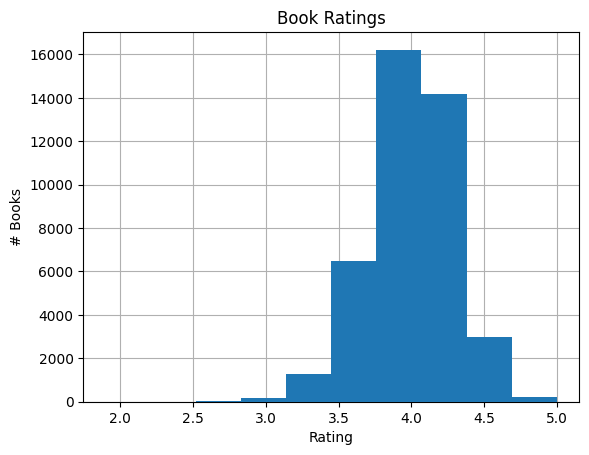

In [10]:
def displayColumnHistogram(
    df: pd.DataFrame,
    col: str,
    xlabel: str,
    ylabel: str = '# Books',
    title: str = ''
):
    """
        Displays the Histogram for column `col` of `df`.
        - `xlabel`: the label for x-axis.
        - `ylabel`: the label for y-axis.
    """

    ax = plt.subplot()
    ax.set_title(title if title else col)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    df[col].hist(ax=ax, grid=True, zorder=3)

printMd('**1.** Book Ratings histogram')
displayColumnHistogram(dataDf, col=DataColumn.RATING, xlabel='Rating', title='Book Ratings')

In [11]:
class AnswerGeneratorQuestion(TypedDict):
    """ Used to store question-specific information. """
    
    qnum: str
    """ Question Number. """
    qtitle: str
    """ Question Title. """
    col: str
    """ Column title. """
    dataFilter: Optional[ Callable[[pd.DataFrame], pd.DataFrame] ]
    """  """
    limit: Optional[int]
    """ Limit for number of results. """

QT = TypeVar("QT", bound=AnswerGeneratorQuestion)
class AnswerGenerator(ABC, Generic[QT]):
    """
        Used to generate `DataFrame` answers on Dataset-related questions.
    """
    def __init__(self) -> None:
        self.questions: List[QT] = []

    def registerQuestions(self, questions: Iterable[QT]):
        self.questions = list(questions)
        return self

    def registerQuestion(self, q: QT):
        self.questions.append(q)
        return self

    def clearQuestions(self):
        self.questions.clear()
        return self
    
    @abstractmethod
    def createDataFrameAnswer(self, q: QT, df: Optional[pd.DataFrame]) -> pd.DataFrame:
        pass

    def generateAnswers(self, df: pd.DataFrame):
        """
            Displays the answer for each question provided to the
            `AnswerGenerator`, using data in `df`.

            The answer includes an inline markdown string,
            as well as the results `DataFrame`.
        """
        
        for q in self.questions:
            filteredDf = q['dataFilter'](df) if q['dataFilter'] else df
            answer = self.createDataFrameAnswer(q, filteredDf)
            limit = q['limit'] if q['limit'] else answer.shape[0]
            
            printMd(f'**{q["qnum"]}**. {q["qtitle"]}:')
            display(answer.head(n=limit))

In [12]:
class TopBooksAnswerGenerator(AnswerGenerator[AnswerGeneratorQuestion]):
    """
        Used to generate `DataFrame` answers on questions regarding
        the top books based on a specific column value.
    """ 
    
    def createDataFrameAnswer(self, q: AnswerGeneratorQuestion, df: pd.DataFrame):
        results = df.sort_values(by=q['col'], ascending=False)
        return results[[DataColumn.TITLE, q['col']]]

In [13]:
questions: List[AnswerGeneratorQuestion] = [
    {
        'qnum': '2',
        'qtitle': 'Top 10 books with the most pages',
        'col': DataColumn.PAGES,
        'limit': 10,
        'dataFilter': None
    },
    {
        'qnum': '3',
        'qtitle': 'Top 10 books with the most 5-star ratings (min 10000)',
        'col': DataColumn.RATINGSTAR5,
        'limit': 10,
        'dataFilter': lambda df: df[df[DataColumn.RATINGSTAR5] > 10000]
    },
]

TopBooksAnswerGenerator().registerQuestions(questions).generateAnswers(dataDf)

**2**. Top 10 books with the most pages:

,title,pages
30698,The Marx Sisters: A Kathy Kolla and David Broc...,999
304,The Wise Man's Fear,994
656,A Breath of Snow and Ashes,993
35898,Hamzanama: The Adventures of Amir Hamza,992
27195,The Ball is Round: A Global History of Soccer,992
14843,The Endymion Omnibus,992
11779,The Braided Path,992
17695,Three Novels of Old New York: The House of Mir...,992
12217,The Last Lion: Winston Spencer Churchill: Visi...,992
36110,"1,000 Places to See Before You Die",992


**3**. Top 10 books with the most 5-star ratings (min 10000):

,title,ratingStar5
32,Harry Potter and the Sorcerer's Stone,4578137
0,The Hunger Games,3444695
2,To Kill a Mockingbird,2363896
71,Harry Potter and the Deathly Hallows,2038930
93,Harry Potter and the Prisoner of Azkaban,1892635
10,The Fault in Our Stars,1784471
4,Twilight,1751460
103,Harry Potter and the Goblet of Fire,1729403
105,Harry Potter and the Half-Blood Prince,1646703
3,Pride and Prejudice,1617567


In [14]:
class TopColumnValuesQuestion(AnswerGeneratorQuestion):
    """
        A question regarding the top values of a primary column (e.g. top Authors) 
        based on their respective total value in a secondary column (e.g. total Ratings).
    """

    countCol: str
    """
        The secondary column. If `== TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN`,
        just count the total rows for each primary column value (`pd.Dataframe.value_counts()`)
    """

    extractor: Optional[Callable[[str], str]]
    """"
        If specified, it is used as custom logic when extracting
        the primary column values (e.g. Author names).
    """

    counter: Optional[Callable[["defaultdict[str, int]", str, Optional[Any]], None]]
    """ If specified, it is used as custom logic when counting the total values. """

    useExtracted: bool
    """
        If specified, the generator will use the primary column values that have already been extracted.
        This is handy in case there are consecutive questions regarding the same primary column.
    """

class TopColumnValuesAnswerGenerator(AnswerGenerator[TopColumnValuesQuestion]):
    """
        Used to generate `DataFrame` answers on questions regarding
        the top values of a primary column (e.g. top Authors)
        based on their respective total value in a secondary column (e.g. total Ratings).
    """

    NO_COUNT_COLUMN = 'no_count_column'
    
    def __init__(self) -> None:
        super().__init__()
        self.__data__: "pd.Series[str]"

    def __extractColumnValues__(self, df: pd.DataFrame, q: TopColumnValuesQuestion):
        if q['extractor']:
            self.__data__ =  df[q['col']].apply(q['extractor'])
        else:
            self.__data__ = df[q['col']]

    def createDataFrameAnswer(self, q: TopColumnValuesQuestion, df: pd.DataFrame):
        if not q['useExtracted']:
            self.__extractColumnValues__(df, q)

        valueCount: defaultdict[str, int] = defaultdict(lambda: 0)
        if q['countCol'] == self.NO_COUNT_COLUMN:

            if q['counter']:
                for v in self.__data__:
                    q['counter'](valueCount, v, None)
                
                ans = pd.DataFrame(
                    valueCount.items(),
                    columns=[q['col'].capitalize(), 'Books']
                ).sort_values(by='Books', ascending=False)
                ans.reset_index(inplace=True, drop=True)

            else:
                ans = self.__data__.value_counts().sort_values(ascending=False).to_frame().reset_index()
                ans.columns = [q['col'].capitalize(), 'Books']            
        else:
            col = q['countCol']
            
            for key, colValue in zip(self.__data__, df[col]):
                if q['counter']:
                    q['counter'](valueCount, key, colValue)
                else:
                    valueCount[key] += colValue

            countColStr = f'Total {q["countCol"]}'
            ans = pd.DataFrame(
                    valueCount.items(),
                    columns=[q['col'].capitalize(), countColStr]
                ).sort_values(by=countColStr, ascending=False)
            ans.reset_index(inplace=True, drop=True)
        
        ans.index += 1
        return ans

In [15]:
questions: List[TopColumnValuesQuestion] = [
    {
        'qnum': '5',
        'qtitle': 'Top 10 Authors with the most books',
        'col': DataColumn.AUTHOR,
        'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
        'limit': 10,
        'dataFilter': None,
        'extractor': lambda s: re.split(r'[,(]', s, maxsplit=1)[0].strip(),
        'counter' : None,
        'useExtracted': False
    },    
    {
        'qnum': '6',
        'qtitle': 'Top 10 Authors with the most ratings',
        'col': DataColumn.AUTHOR,
        'countCol': DataColumn.NUMRATINGS,
        'limit': 10,
        'dataFilter': None,
        'extractor': None,
        'counter' : None,
        'useExtracted': True
    },
    {
        'qnum': '8',
        'qtitle': 'Top 10 Languages used in the most books',
        'col': DataColumn.LANGUAGE,
        'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
        'limit': 10,
        'dataFilter': None,
        'extractor': None,
        'counter' : None,
        'useExtracted': False
    },
    {
        'qnum': '9',
        'qtitle': 'Top 10 Publishers with the most books',
        'col': DataColumn.PUBLISHER,
        'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
        'limit': 10,
        'dataFilter': None,
        'extractor': None,
        'counter' : None,
        'useExtracted': False
    }
]

def buildYearFilter(y: int) -> Callable[[pd.DataFrame], pd.DataFrame]:
    return lambda df: df[df[DataColumn.PUBLISHYEAR] == y]

for i, y in enumerate(range(2000, 2016, 5)):
    questions.append({
        'qnum': f'7({i + 1})',
        'qtitle': f'Top 10 Authors with the most books in {y}',
        'col': DataColumn.AUTHOR,
        'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
        'limit': 10,
        'dataFilter': buildYearFilter(y),
        'extractor': None,
        'counter' : None,
        'useExtracted': False
    })
questions = sorted(questions, key=lambda q: q['qnum'])
TopColumnValuesAnswerGenerator().registerQuestions(questions).generateAnswers(dataDf)

**5**. Top 10 Authors with the most books:

,Author,Books
1,Stephen King,90
2,Nora Roberts,89
3,James Patterson,82
4,Agatha Christie,81
5,Erin Hunter,67
6,J.D. Robb,63
7,Terry Pratchett,62
8,Francine Pascal,60
9,Carolyn Keene,57
10,Karen Kingsbury,57


**6**. Top 10 Authors with the most ratings:

,Author,Total numRatings
1,J.K. Rowling,24342485
2,Stephen King,12994174
3,Suzanne Collins,11836703
4,Stephenie Meyer,10562763
5,Rick Riordan,8432058
6,J.R.R. Tolkien,8086696
7,Dan Brown,7014203
8,John Green,6793133
9,Cassandra Clare,6650456
10,George Orwell,6230842


**7(1)**. Top 10 Authors with the most books in 2000:

,Author,Books
1,Agatha Christie,7
2,Larry McMurtry,5
3,Lawrence Block (Goodreads Author),5
4,Katherine Applegate,5
5,Linda Howard,4
6,P.G. Wodehouse,4
7,Jude Watson (Goodreads Author),3
8,Elizabeth Peters,3
9,Francine Rivers (Goodreads Author),3
10,"Jude Watson (Goodreads Author), Cliff Nielsen ...",3


**7(2)**. Top 10 Authors with the most books in 2005:

,Author,Books
1,Terry Pratchett,9
2,"Bodie Thoene (Goodreads Author), Brock Thoene",9
3,Georgette Heyer,9
4,R.L. Stine (Goodreads Author),8
5,Ted Dekker (Goodreads Author),8
6,Tamora Pierce (Goodreads Author),8
7,Laurell K. Hamilton (Goodreads Author),7
8,Nora Roberts (Goodreads Author),7
9,C.S. Lewis,7
10,"CLAMP, William Flanagan (Translator)",7


**7(3)**. Top 10 Authors with the most books in 2010:

,Author,Books
1,"Mary Pope Osborne, Salvatore Murdocca (Illustr...",8
2,Laurann Dohner,7
3,Joey W. Hill (Goodreads Author),5
4,Rachel Caine (Goodreads Author),5
5,Jim Butcher (Goodreads Author),5
6,Meg Cabot (Goodreads Author),5
7,Gena Showalter (Goodreads Author),5
8,Christopher Pike,5
9,"Will Durant, Ariel Durant, عبد الرحمن عبد الله...",5
10,T.M. Nielsen,4


**7(4)**. Top 10 Authors with the most books in 2015:

,Author,Books
1,Jennifer L. Armentrout (Goodreads Author),5
2,Anna Gallegos (Goodreads Author),4
3,Penny Reid (Goodreads Author),4
4,Anne Jolin (Goodreads Author),4
5,Meredith Wild (Goodreads Author),4
6,Suzanne Wright (Goodreads Author),3
7,Sherrilyn Kenyon (Goodreads Author),3
8,Marissa Meyer (Goodreads Author),3
9,Jennifer Donnelly (Goodreads Author),3
10,C.S. Lewis,3


**8**. Top 10 Languages used in the most books:

,Language,Books
1,English,37005
2,Arabic,744
3,Spanish,519
4,French,494
5,German,404
6,Indonesian,300
7,Portuguese,298
8,Italian,214
9,Dutch,192
10,Turkish,173


**9**. Top 10 Publishers with the most books:

,Publisher,Books
1,Vintage,559
2,HarperCollins,494
3,Penguin Books,410
4,Ballantine Books,383
5,Bantam,346
6,Avon,305
7,Pocket Books,304
8,Del Rey,282
9,Berkley,276
10,Tor Books,275


**10.** Relationship between number of pages and ratings

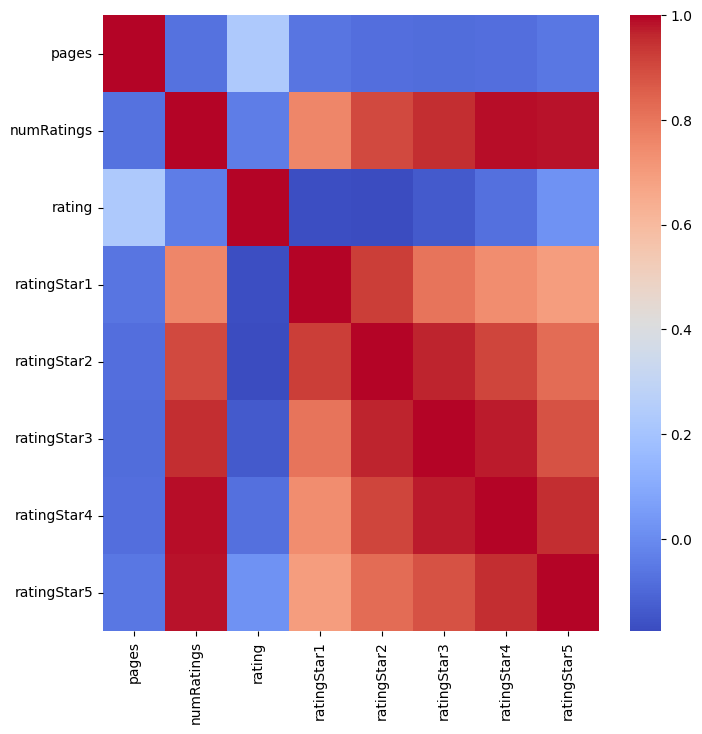

In [16]:
def drawHeatmap(df: pd.DataFrame, ax: plt.Axes, cmap: str = "coolwarm", **kwargs):
    _ = sns.heatmap(df.corr(), ax=ax, cmap=cmap, **kwargs)

_, axes = plt.subplots(1, 1, figsize=(8,8))
cols = [
    DataColumn.PAGES,
    DataColumn.NUMRATINGS,
    DataColumn.RATING,
    DataColumn.RATINGSTAR1,
    DataColumn.RATINGSTAR2,
    DataColumn.RATINGSTAR3,
    DataColumn.RATINGSTAR4,
    DataColumn.RATINGSTAR5
]

def pageStrToInt(s: str):
    try:
        return int(s)
    except ValueError:
        return int(s.split(maxsplit=1)[0])

dataDf[DataColumn.PAGES] = dataDf[DataColumn.PAGES].apply(pageStrToInt)
drawHeatmap(dataDf[dataDf[DataColumn.PAGES] > 1000][cols], axes)

In [17]:
def countListRowStrings(d: "defaultdict[str, int]", s: str, listExtractor: Callable[[str], List[str]]):
    items: List[str] = listExtractor(s)
    for i in items:
        d[i] += 1

def awardTitlesExtractor(awardListStr: str) -> List[str]:    
    awardList: List[str] = ast.literal_eval(awardListStr)
    awards = []
    for s in awardList:
        awards.append(re.sub(fr'[(]{YearExtractor.YEAR_RE_NO_GROUP}[)]', repl='', string=s).strip())
    return awards

TopColumnValuesAnswerGenerator().registerQuestions([
    {
        'qnum': '11',
        'qtitle': 'Top Genres of the most books',
        'col': DataColumn.GENRES,
        'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
        'limit': 10,
        'dataFilter': None,
        'extractor': None,
        'counter': lambda d, s, _: countListRowStrings(d, s, ast.literal_eval),
        'useExtracted': False
    },
    {
        'qnum': '12',
        'qtitle': 'Top Awards of the most books',
        'col': DataColumn.AWARDS,
        'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
        'limit': 10,
        'dataFilter': None,
        'extractor': None,
        'counter': lambda d, s, _: countListRowStrings(d, s, awardTitlesExtractor),
        'useExtracted': False
    }
]).generateAnswers(dataDf)

**11**. Top Genres of the most books:

,Genres,Books
1,Fiction,28657
2,Fantasy,13481
3,Romance,13159
4,Young Adult,10453
5,Contemporary,8919
6,Nonfiction,7310
7,Adult,7228
8,Novels,7224
9,Historical Fiction,7098
10,Mystery,7075


**12**. Top Awards of the most books:

,Awards,Books
1,Dorothy Canfield Fisher Children's Book Award ...,317
2,Lincoln Award Nominee,246
3,Rhode Island Teen Book Award Nominee,214
4,Carnegie Medal Nominee,160
5,Goodreads Choice Award Nominee for Young Adult...,155
6,Rebecca Caudill Young Readers' Book Award Nominee,138
7,Goodreads Choice Award Nominee for Fiction,137
8,Goodreads Choice Award Nominee for Romance,136
9,Missouri Gateway Readers Award Nominee,136
10,Goodreads Choice Award Nominee for Young Adult...,134


In [18]:
TopColumnValuesAnswerGenerator().registerQuestion({
    'qnum': '13',
    'qtitle': 'Books published by year',
    'col': DataColumn.PUBLISHYEAR,
    'countCol': TopColumnValuesAnswerGenerator.NO_COUNT_COLUMN,
    'limit': 15,
    'dataFilter': None,
    'extractor': None,
    'counter': None,
    'useExtracted': False
}).generateAnswers(dataDf)

**13**. Books published by year:

,Publishyear,Books
1,2012,2642
2,2006,2432
3,2013,2418
4,2011,2399
5,2010,2235
6,2007,2217
7,2009,2014
8,2014,1995
9,2005,1902
10,2008,1866


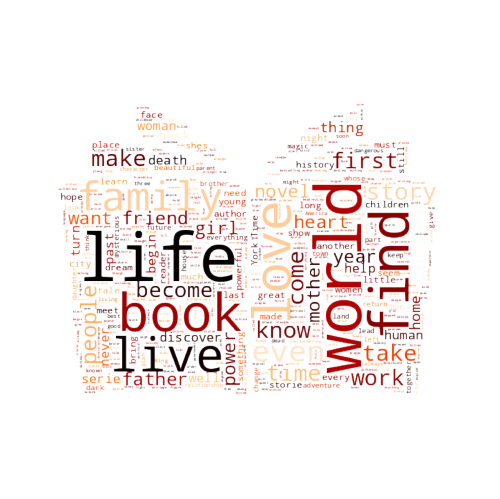

<Figure size 4000x2000 with 0 Axes>

Top 10 most popular words used in book descriptions:

,Word
1,life
2,world
3,find
4,book
5,love
6,live
7,family
8,even
9,story
10,time


In [30]:
def displayWordcloud(text: str) -> WordCloud:

    def downloadImageMask() -> "np.ndarray | None":
        IMG_PATH = 'https://img.freepik.com/premium-vector/book-logo_535345-3487.jpg'

        res = requests.get(IMG_PATH)

        if res.ok:
            return np.array( Image.open(io.BytesIO(res.content)) )
        else:
            return None

    stopWordsSet = set()
    stopWordsSet.update(wordcloud.STOPWORDS)
    stopWordsSet.update(nltk.corpus.stopwords.words('english'))
    cloud = WordCloud(
        background_color="rgba(255, 255, 255, 0)", mode="RGBA",
        colormap=plt.colormaps['gist_heat'],
        width=2000, height=1000,
        max_words=500,
        min_word_length=4,
        stopwords=stopWordsSet,
        mask=downloadImageMask()
    ).generate(text)

    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.imshow(cloud, interpolation='bilinear')
    plt.figure(figsize=(40, 20))
    plt.show()

    return cloud

def displayTopWordcloudWords(wcloud: WordCloud, n: int):
    printMd(f'Top {n} most popular words used in book descriptions:')
    topWords = pd.DataFrame(wcloud.words_.keys())
    topWords.columns=['Word']
    topWords.index += 1
    display(topWords.head(n))

descriptionsTotal = (
    ' '.join(d for d in dataDf[DataColumn.DESCRIPTION])
    .translate(str.maketrans('', '', string.punctuation))
)
wcloud = displayWordcloud(descriptionsTotal)
displayTopWordcloudWords(wcloud, 10)

In [20]:
# temp = dataDf[[DataColumn.GENRES, DataColumn.AWARDS]]